In [2]:
# Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/naf/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


' If SSL error _ssl.c:997: \n    pip install --upgrade certifi'

In [271]:
def Process(fname):
    data = pd.read_csv(fname, names=np.arange(12), sep='\s+')
    thetas, nd = [], []
    for i in range(len(data)):
        if i%2: thetas += [data.iloc[i,5]] # Vol dens of block 2 adj. to surf
        else:   nd += [data.iloc[i,:6].to_list()]
    return pd.concat([pd.DataFrame(nd,  columns=['it', 'lx', 'free', 'freeDiff', 'inCompMax', 'andErr']), pd.Series(thetas, name='theta')], axis=1)

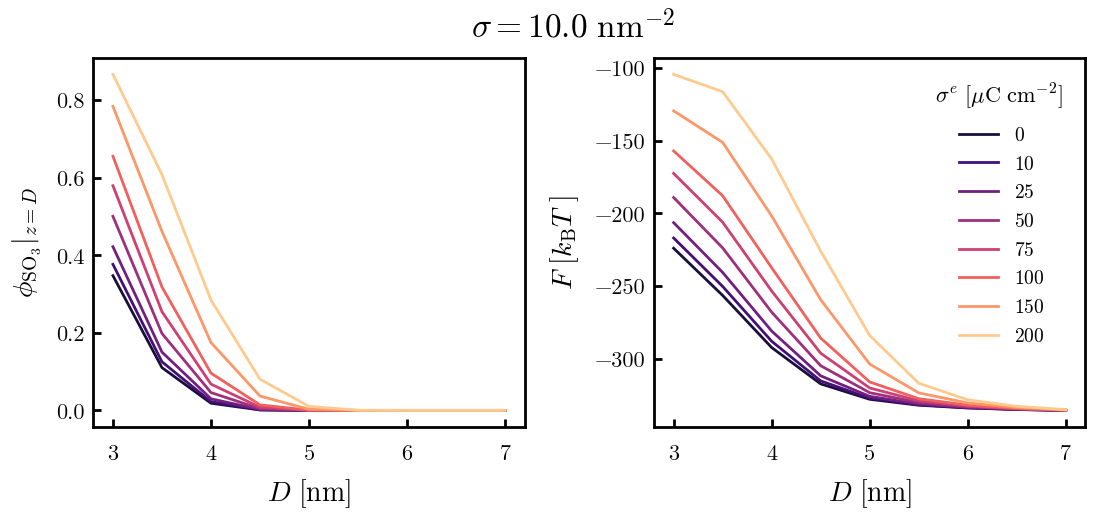

In [248]:
lx30, lx35, lx40, lx45 = Process(GIT+'s1000_lx30.txt'), Process(GIT+'s1000_lx35.txt'), Process(GIT+'s1000_lx40.txt'), Process(GIT+'s1000_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s1000_lx50.txt'), Process(GIT+'s1000_lx55.txt'), Process(GIT+'s1000_lx60.txt'), Process(GIT+'s1000_lx65.txt'), Process(GIT+'s1000_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
)
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

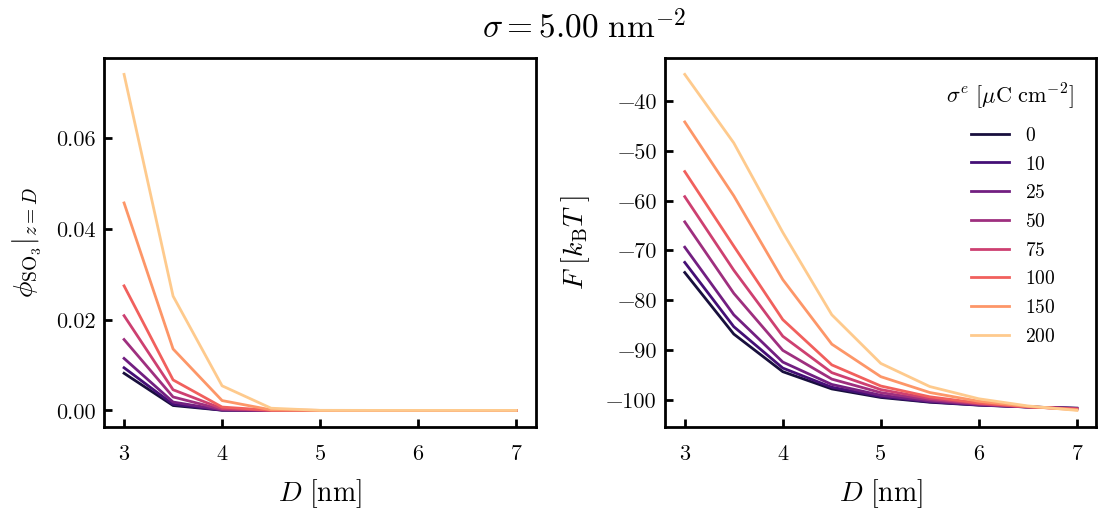

In [244]:
lx30, lx35, lx40, lx45 = Process(GIT+'s500_lx30.txt'), Process(GIT+'s500_lx35.txt'), Process(GIT+'s500_lx40.txt'), Process(GIT+'s500_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s500_lx50.txt'), Process(GIT+'s500_lx55.txt'), Process(GIT+'s500_lx60.txt'), Process(GIT+'s500_lx65.txt'), Process(GIT+'s500_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
)
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

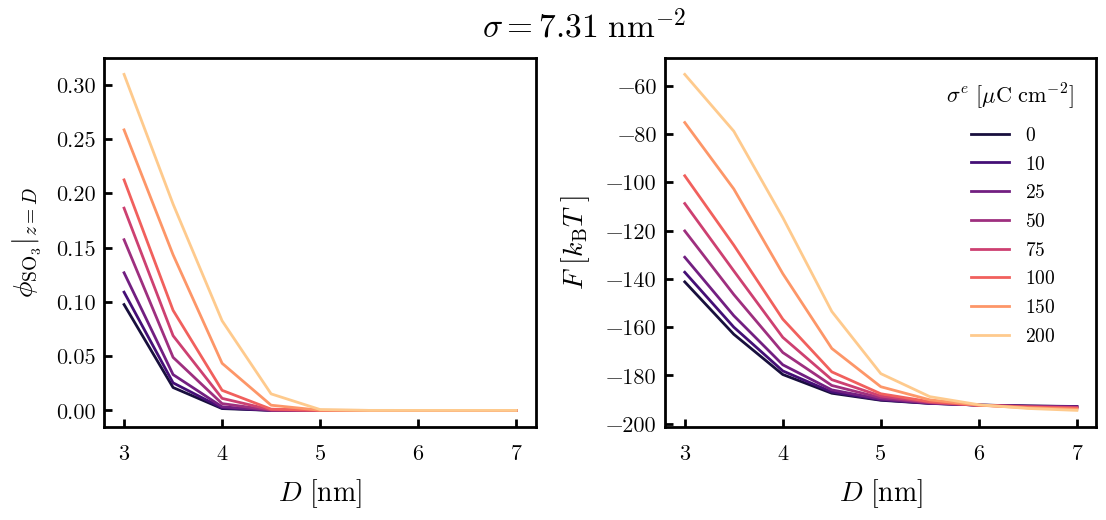

In [243]:
lx30, lx35, lx40, lx45 = Process(GIT+'s731_lx30.txt'), Process(GIT+'s731_lx35.txt'), Process(GIT+'s731_lx40.txt'), Process(GIT+'s731_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s731_lx50.txt'), Process(GIT+'s731_lx55.txt'), Process(GIT+'s731_lx60.txt'), Process(GIT+'s731_lx65.txt'), Process(GIT+'s731_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
)
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

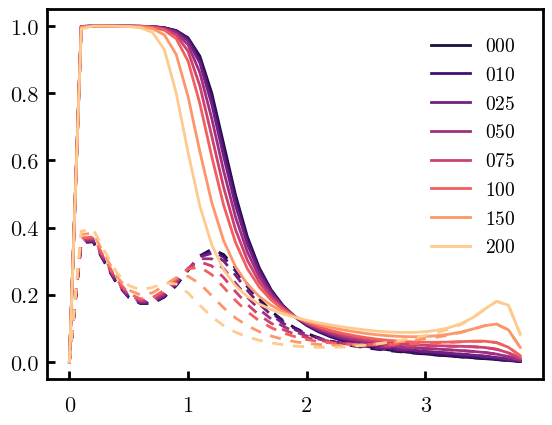

In [284]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731_lx400e'
fig, ax = plt.subplots(1,1)
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    plt.plot(ph.z[:-1], ph.overall[:-1], ls='-', c=c, label=r'${:}$'.format(i))
    plt.plot(ph.z[:-1], ph.block5[:-1], ls=(0,(4,3.5)), c=c)
    
plt.legend()
tjy.ticks()